# Offline Phase: generation of the POD modes

This notebook implements the offline phase of the following algorithms:

- Proper Orthogonal Decomposition (POD)

In particular, the basis functions (named modes) are generated through the POD procedure.

The snapshots are related to the Buoyant Cavity problem in fluid dynamics, governed by the Navier-Stokes equations, including energy, under the Boussinesq approximation. In particular, the snapshots have been generated using the case reported in [ROSE-ROM4FOAM tutorials](https://ermete-lab.github.io/ROSE-ROM4FOAM/Tutorials/BuoyantCavity/problem.html).

In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm

from mpi4py import MPI
from dolfinx.io import gmshio
import gmsh
from dolfinx.fem import Function, FunctionSpace
import ufl

from pyforce.offline.pod import POD
from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store

path = './Snapshots/'

var_names = ['p', 'norm_T', 'U']
tex_var_names = ['p', 'T', r'\mathbf{u}']

The snapshots are dependent on two different parameters: the Reynolds and the Richardson number, split into train and test set
\begin{equation}
\begin{array}{cc}
Re_{train} = [15:5:150] & Ri_{train} = [0.2:0.4:5] \\
Re_{test} = [17.5:10:147.5] & Ri_{test} = [0.4:0.8:44] 
\end{array}
\end{equation}


In [3]:
dRe = 5.
dRi = 0.4

# Train/Test Parameters
Re_train_test = [np.arange(15,  150+dRe/2, dRe), np.arange(15+dRe/2,  150+dRe/2, dRe*2)]
Ri_train_test = [np.arange(0.2,   5+dRi/2, dRi), np.arange(0.2+dRi/2,   5+dRi/2, dRi*2)  ]

Let us generate the mesh for importing OpenFOAM dataset into *dolfinx*

In [4]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cavity.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )
gmsh.finalize()

########################################################################################################

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

Info    : Reading 'cavity.geo'...
Info    : Done reading 'cavity.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000233847s, CPU 0.000251s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00335411s, CPU 0s)
Info    : 16384 nodes 32770 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 1.4808e-06s, CPU 5e-06s)


Let us define the functional space onto which the OpenFOAM data have been projected; then, the snapshots can be imported.

In [5]:
fun_spaces = [FunctionSpace(domain, ('Lagrange', 1)), FunctionSpace(domain, ('Lagrange', 1)), FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1))]

train_snaps = dict()
test_snaps  = dict()

training = True

for field_i, field in enumerate(var_names):
    
    if training:
        path_snap = path+'TrainSet_'+field
    else:
        path_snap = path+'TestSet_' +field
    tmp = ImportH5(fun_spaces[field_i], path_snap, field)
    
    if training:
        train_snaps[field] = tmp[0]
    else:
        test_snaps[field] = tmp[0]

## POD algorithm

A dict will be created with the POD class of each field.

In [6]:
pod_data = dict()

for field in var_names:
    pod_data[field] = POD(train_snaps[field], field, verbose=True, use_scipy=True)

Computing p correlation matrix: 364.000 / 364.00 - 0.269 s/it
Computing norm_T correlation matrix: 364.000 / 364.00 - 0.267 s/it
Computing U correlation matrix: 364.000 / 364.00 - 0.369 s/it


In [8]:
pod_data[var_names[1]] = POD(train_snaps[var_names[1]], var_names[1], verbose=True, use_scipy=True)

Computing norm_T correlation matrix: 364.000 / 364.00 - 0.269 s/it


Let us plot the eigenvalues

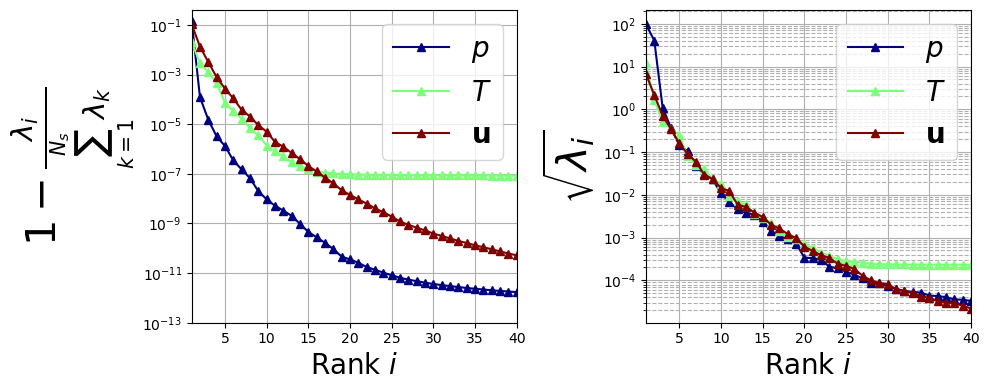

In [9]:
PODeigFig = plt.figure( figsize= (10,4))

plt.subplot(1,2,1)
color = iter(cm.jet(np.linspace(0, 1, len(var_names))))
for field_i, field in enumerate(var_names):
    c = next(color)
    plt.semilogy(np.arange(1,pod_data[field].eigenvalues.size+1,1),
                 1 - np.cumsum(pod_data[field].eigenvalues)/sum(pod_data[field].eigenvalues), "-^", 
                 c=c, label = "$" +tex_var_names[field_i]+"$", linewidth=1.5)   
plt.xlabel(r"Rank $i$",fontsize=20)
plt.xticks(np.arange(0,40+1,5))
plt.xlim(1,40)
plt.ylim(1e-13, .4)
plt.ylabel(r"$1-\frac{\lambda_i}{\sum_{k=1}^{N_s} \lambda_k}$",fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=20)

plt.subplot(1,2,2)
color = iter(cm.jet(np.linspace(0, 1, len(var_names))))
for field_i, field in enumerate(var_names):
    c = next(color)
    plt.semilogy(np.arange(1,pod_data[field].eigenvalues[:40].size+1,1),
                 np.sqrt(pod_data[field].eigenvalues[:40]), "-^", 
                 c=c, label = "$" +tex_var_names[field_i]+"$", linewidth=1.5)   
plt.xlabel(r"Rank $i$",fontsize=20)
plt.xticks(np.arange(0,40+1,5))
plt.xlim(1,40)
plt.ylabel(r"$\sqrt{\lambda_i}$",fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=20)

plt.tight_layout()

### Definition of the modes
Let us define and save the POD modes.

In [19]:
Nmax = 20

path_offline = './Offline_results/'
if not os.path.exists(path_offline+'/BasisFunctions'):
    os.makedirs(path_offline+'/BasisFunctions')

for field in var_names:
    pod_data[field].compute_basis(train_snaps[field], Nmax, normalise = True)
    store(domain, pod_data[field].PODmodes, 'POD_' +field, path_offline+'/BasisFunctions/basisPOD_' + field)

### Computing the training error and reduced coefficient
Then, let us compute the training errors and the POD basis coefficients. 

In [20]:
train_PODcoeff = dict()

train_abs_err = np.zeros((Nmax, len(var_names)))
train_rel_err = np.zeros((Nmax, len(var_names)))

for field_i, field in enumerate(var_names):
    tmp = pod_data[field].train_error(train_snaps[field], Nmax, verbose = True)

    train_abs_err[:, field_i] = tmp[0].flatten()
    train_rel_err[:, field_i] = tmp[1].flatten()
    
    train_PODcoeff[field] = tmp[2]

Computing train error p: 364.000 / 364.00 - 0.095 s/it
Computing train error norm_T: 364.000 / 364.00 - 0.092 s/it
Computing train error U: 364.000 / 364.00 - 0.130 s/it


Let us build the store the coefficients of the reduced basis coefficients to be later used.

In [27]:
for field_i in range(len(var_names)):
    pickle.dump(train_PODcoeff, open(path_offline+'coeffs.pod', 'wb'))

The max absolute and relative reconstruction error is compared for the different algorithms, given the following definitions
\begin{equation*}
\begin{split}
E_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\\
\varepsilon_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}
\end{split}
\end{equation*}
given $\mathcal{P}_N[u]$ the reconstruction operator with $N$ basis functions.

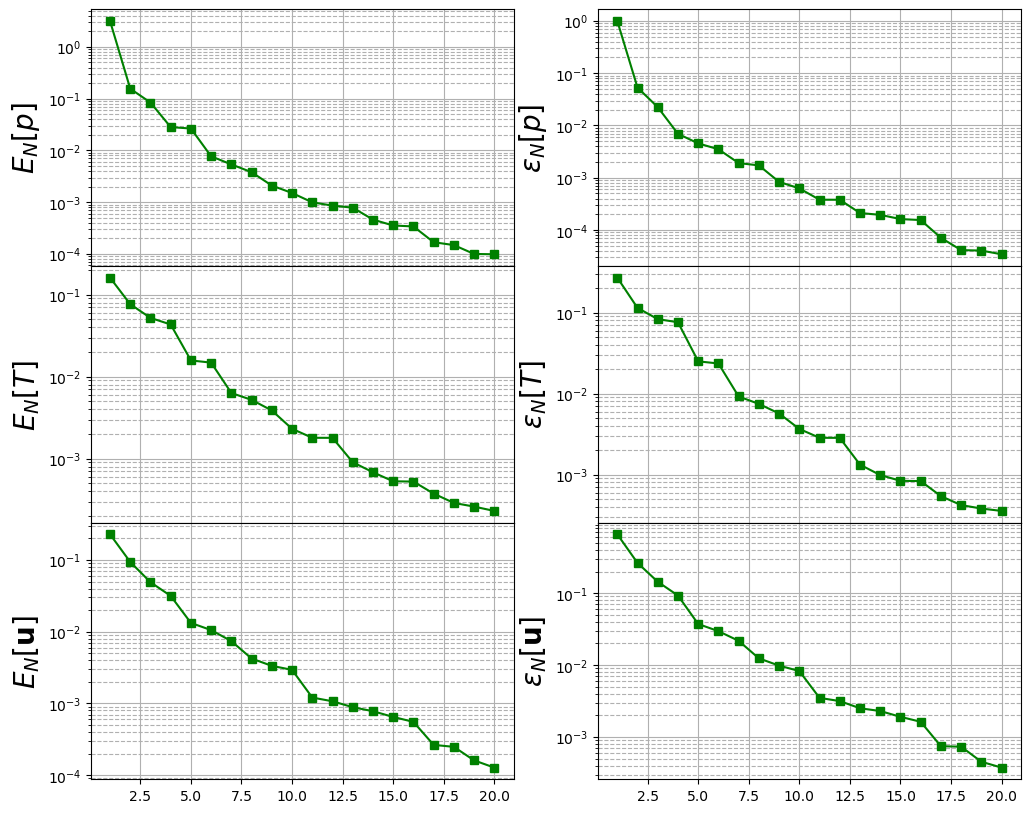

In [29]:
TrainingErrFig, axs = plt.subplots(nrows = len(var_names), ncols = 2, sharex = True, figsize = (12,10) )

Nmax = 20
M = np.arange(1,Nmax+1,1)

for ii in range(len(var_names)):
    
    axs[ii, 0].semilogy(M, train_abs_err[:Nmax, ii], 'g-s',   label = r'POD')
    axs[ii, 1].semilogy(M, train_rel_err[:Nmax, ii], 'g-s',   label = r'POD')

    axs[ii, 0].set_ylabel(r"$E_N["+tex_var_names[ii]+"]$",fontsize=20)
    axs[ii, 1].set_ylabel(r"$\varepsilon_N["+tex_var_names[ii]+"]$",fontsize=20)
    
axs[1, 0].set_xlabel(r"Rank $N$",fontsize=20)
axs[1, 1].set_xlabel(r"Rank $N$",fontsize=20)
    
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')   

TrainingErrFig.subplots_adjust(hspace = 0)

### Post-process: plotting modes
The POD modes are plotted using `pyvista`.

In [50]:
import vtk
import pyvista as pv
from pyforce.tools.functions_list import FunctionsList
import dolfinx

pv.start_xvfb()

def vector_grids(fun: dolfinx.fem.Function, mag_plot: bool, varname='u'):
    
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
    grid[varname] = values

    if mag_plot:
        warped = grid.warp_by_vector(varname, factor=0.0) 
    else:
        warped = grid.glyph(varname, factor=0.075, tolerance=0.025)
        
    return warped, values

def grids(fun: dolfinx.fem.Function):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data['fun'] = fun.x.array[:].real
    u_grid.set_active_scalars('fun')
    return u_grid

def plotModes( pod_modes: FunctionsList, varname: str, shape : list,
               mag_plot = True, colormap = cm.jet):  
    
    nrows = shape[0]
    ncols = shape[1]
    
    resolution = [900 * ncols, 900 * nrows]
    plotter = pv.Plotter(shape=shape, off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 20
    title_fontsize = 30
    zoom = 1.05
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.1,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.885,
                    shadow=False) 
    
    if pod_modes.fun_space.num_sub_spaces > 0:
        vector_plot = True
    else:
        vector_plot = False
    
    idx = 0
    for row in range(nrows):
        for col in range(ncols):
            if vector_plot:
                warped, values = vector_grids(pod_modes.map(idx), mag_plot, varname=varname)
                clim = [0., max(np.sqrt(values[:, 0]**2+values[:, 1]**2+values[:, 2]**2))]
            else:
                warped = grids(pod_modes.map(idx))
                clim = [min(pod_modes(idx)), max(pod_modes(idx))]
                
            plotter.subplot(row, col)
            dict_cb['title'] = '$'+varname+'$'+' - POD mode '+str(idx+1)
            plotter.add_mesh(warped, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
            plotter.view_xy()
            plotter.camera.zoom(zoom)
            
            idx += 1

    plotter.set_background('white', top='white')
    plotter.show()

Let us plot the first 4 POD modes of each variable.

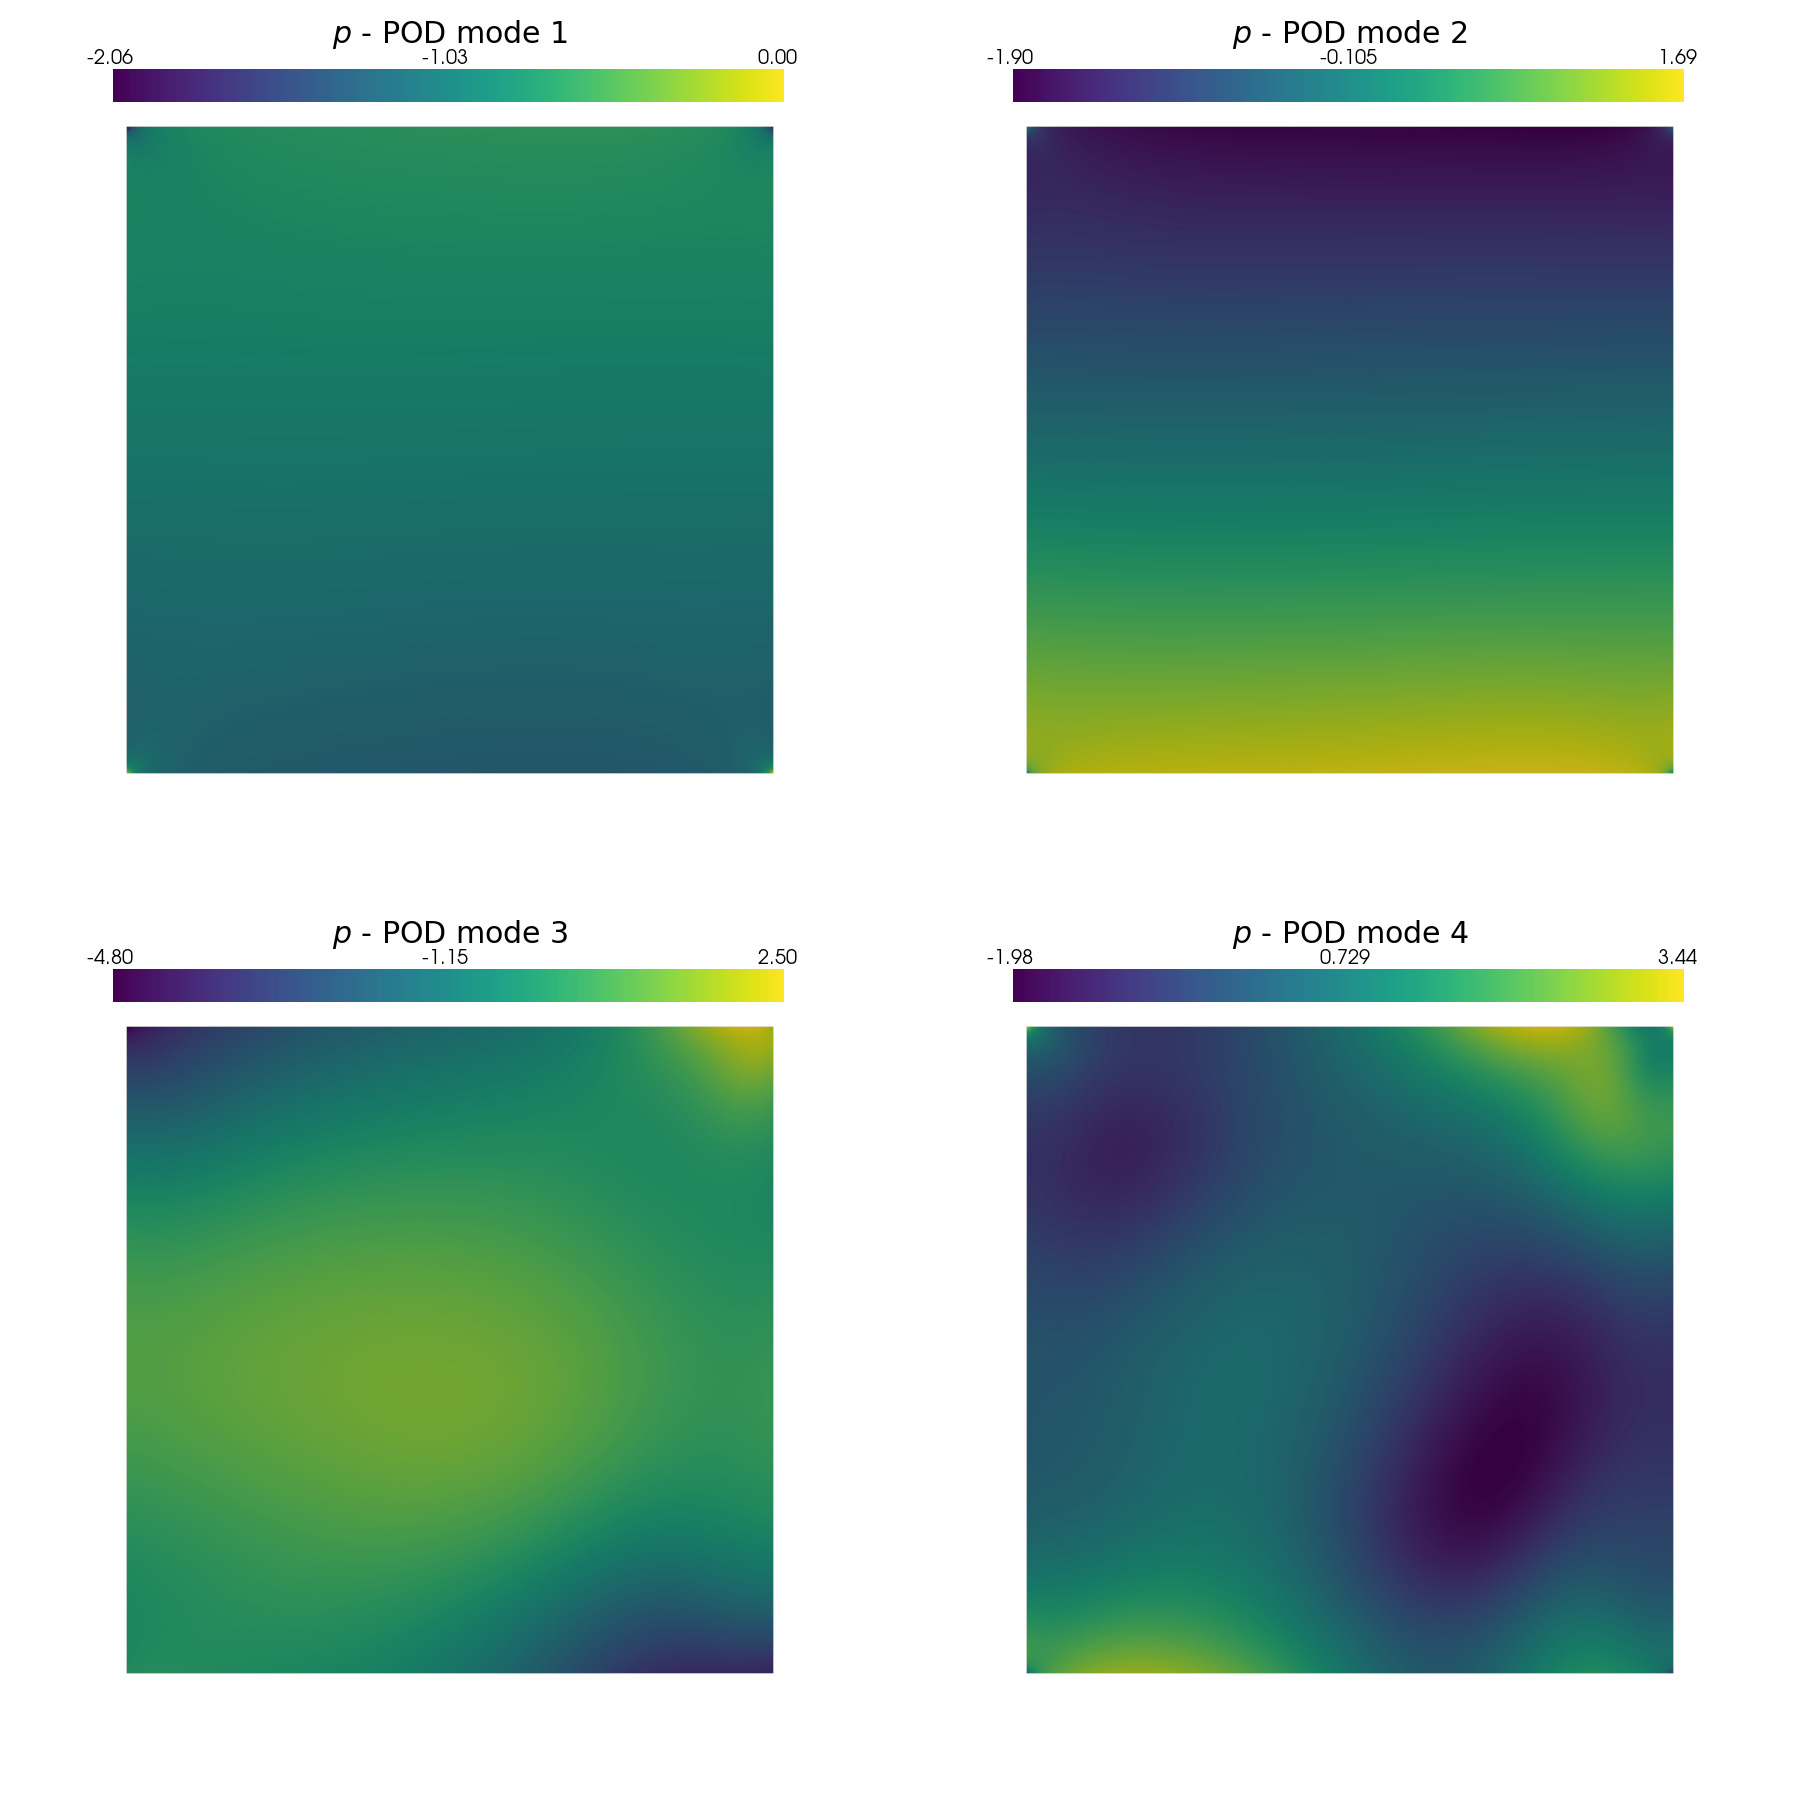

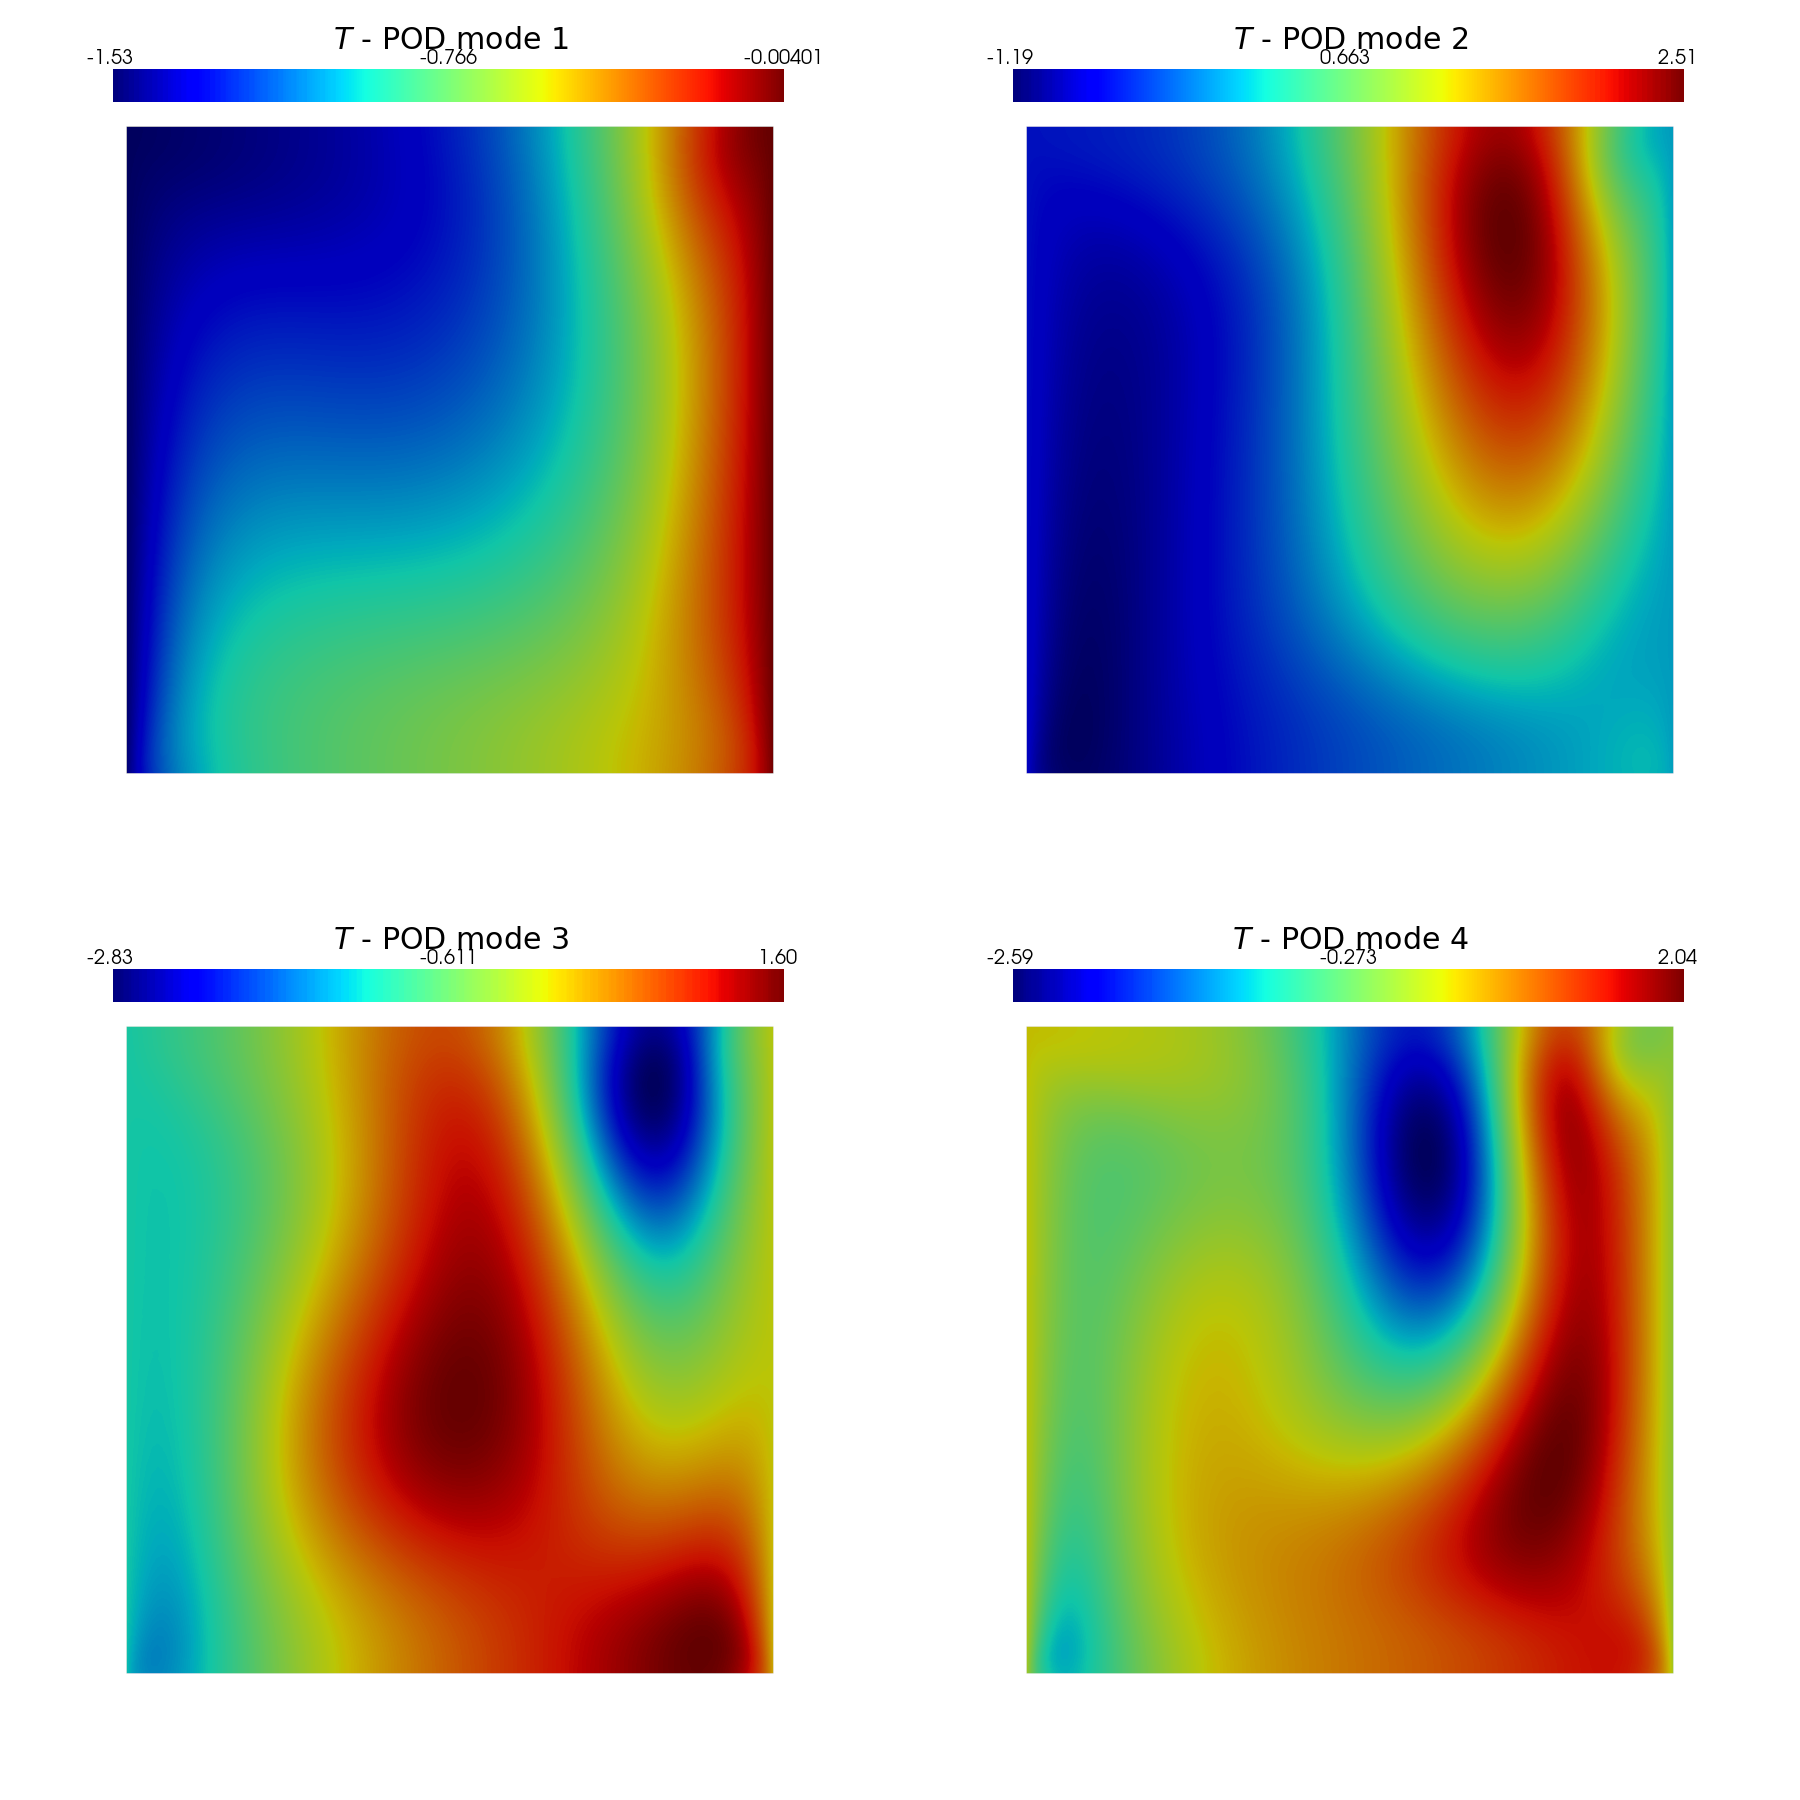

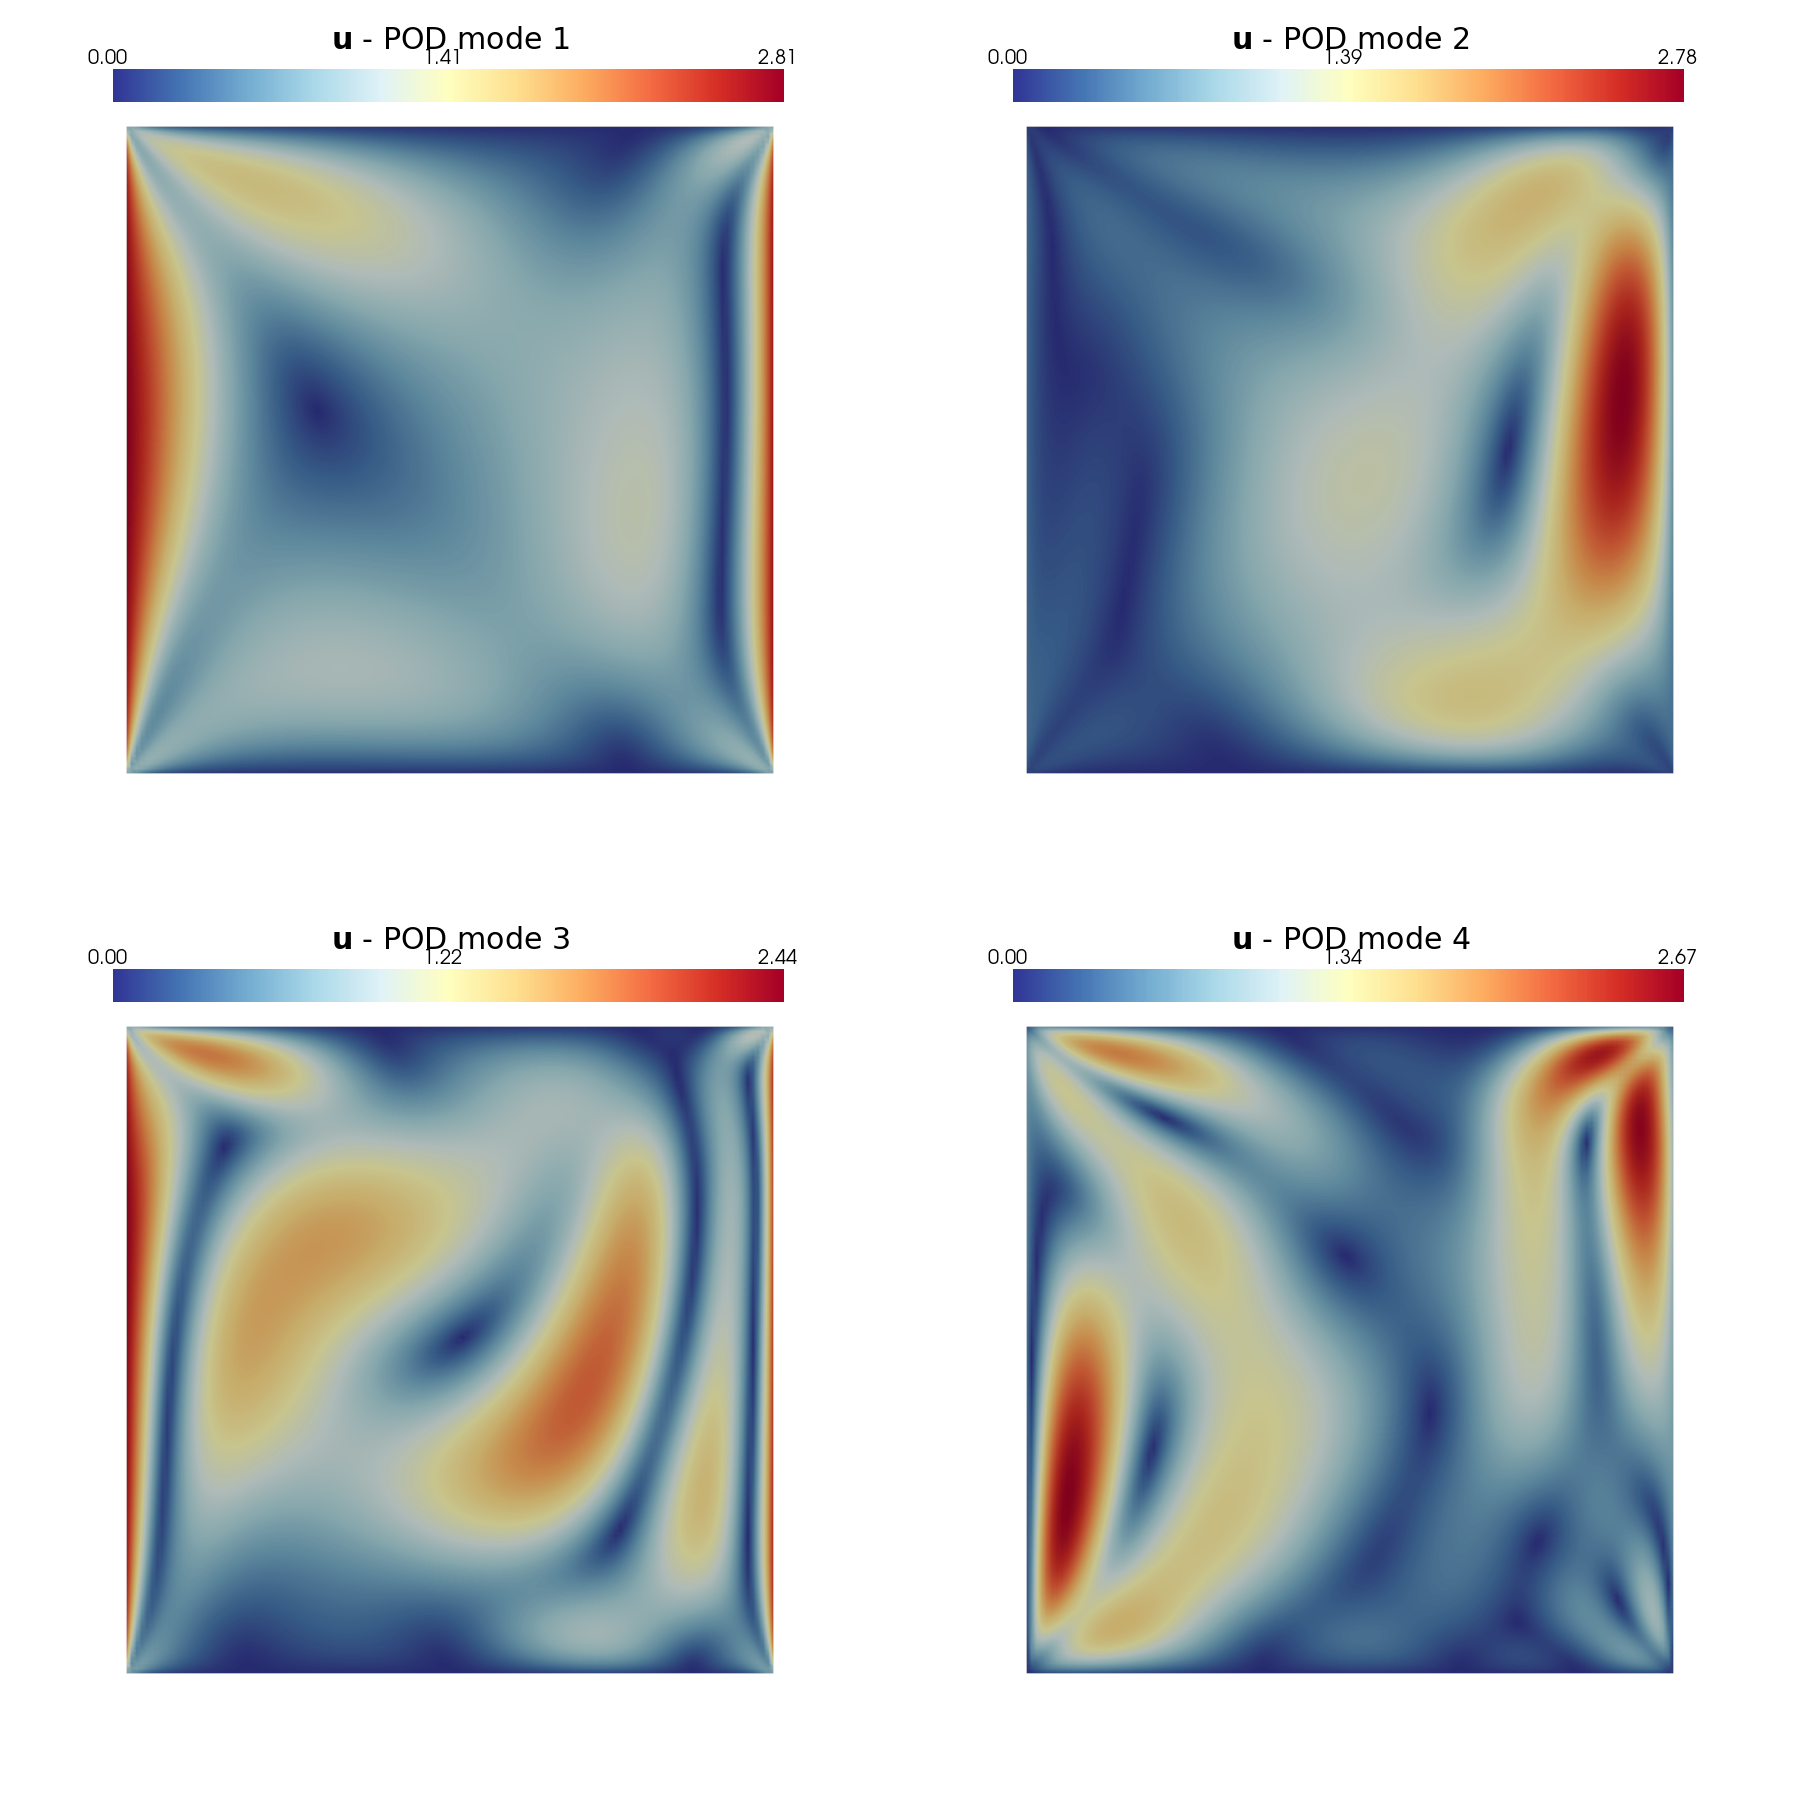

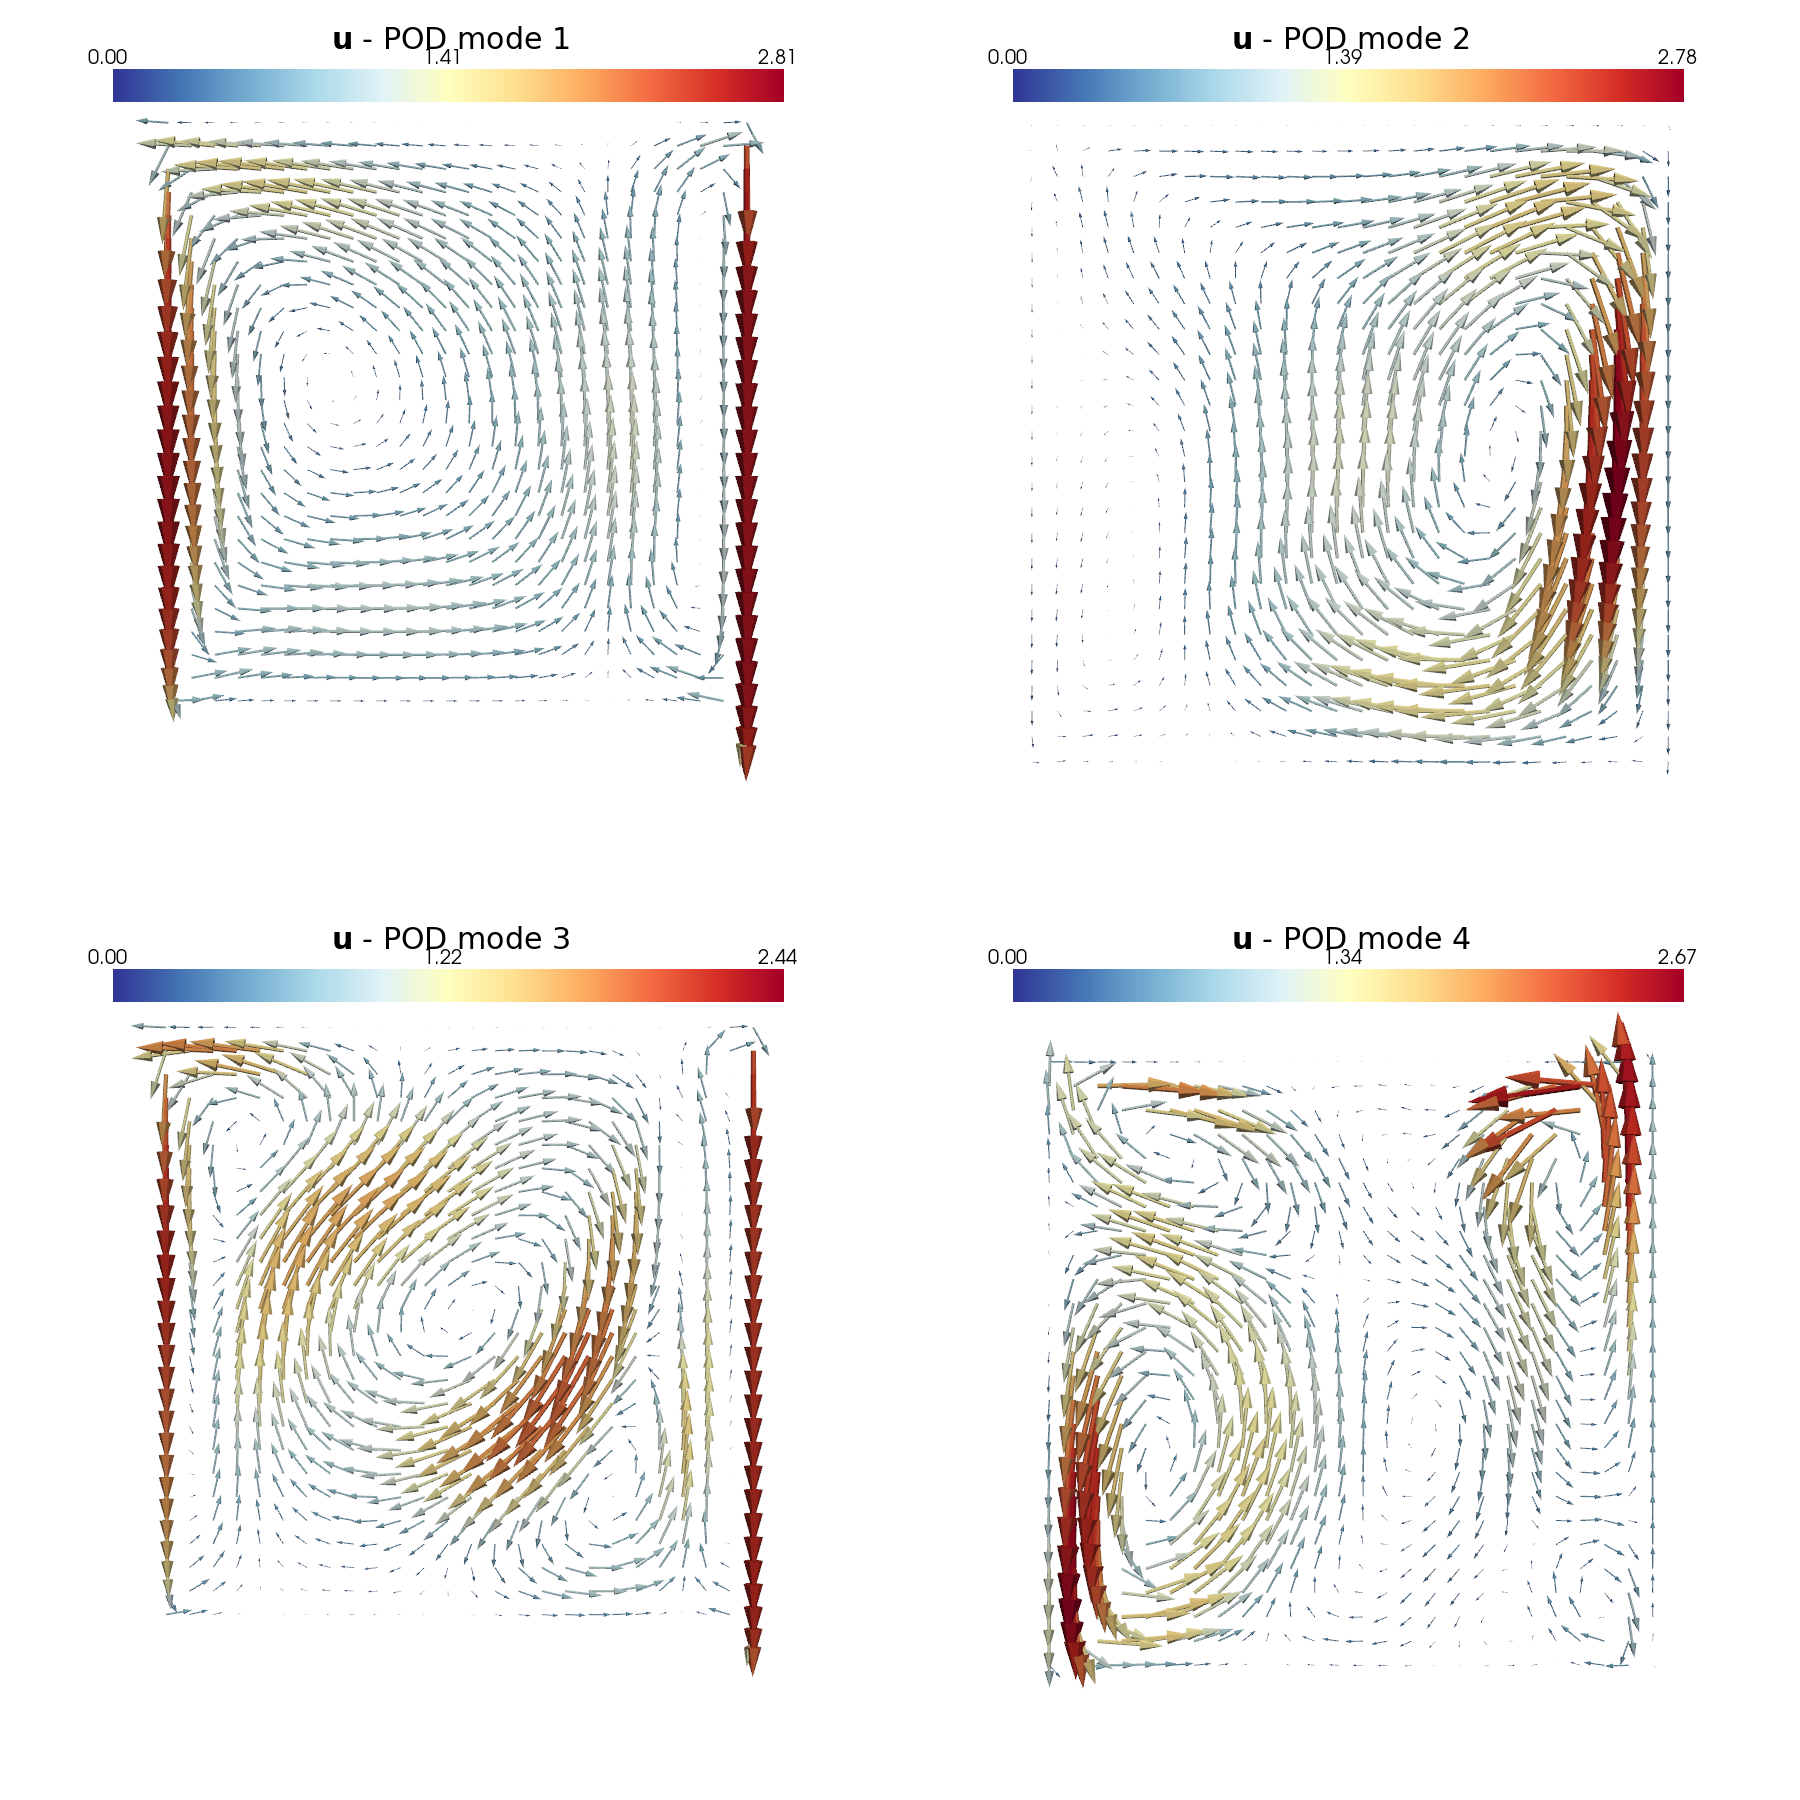

In [52]:
plotModes(pod_data[var_names[0]].PODmodes, tex_var_names[0], shape = [2,2], colormap=cm.viridis)
plotModes(pod_data[var_names[1]].PODmodes, tex_var_names[1], shape = [2,2], colormap=cm.jet)

plotModes(pod_data[var_names[2]].PODmodes, tex_var_names[2], shape = [2,2], colormap=cm.RdYlBu_r)
plotModes(pod_data[var_names[2]].PODmodes, tex_var_names[2], shape = [2,2], mag_plot = False, colormap=cm.RdYlBu_r)